In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
%matplotlib inline

if 0:
    # the following names should be changed for each use
    # specify the location and name of the DEM
    fdir = "D:\\crs\\proj\\2017_Ontario\\2017-07-13_Crescent_Charles\\"
    fname = ("2017-07-13_Crescent_Charles_DEM_v3_5cm.tif")
    # specify the name of the transect file (assumed to be in same directory)
    tfname = '2017-07-12-13_Crescent_Bar_Lake_Bluffs_trans.txt'
    # text for plot titles
    ttext = "Crescent Bar / Charles Point"
    
if 1:
    # the following names should be changed for each use
    # specify the location and name of the DEM
    fdir = "D:\\crs\\proj\\2015_Sandwich\\2017-09-18_U039_SandwichTNB\\products\\"
    fname = ("2017-09-18_U039_SandwichTNB_v3_DEM_10cm.tif")
    # specify the name of the transect file (assumed to be in same directory)
    tfname = '2017-09_18_trans.txt'
    # text for plot titles
    ttext = "Sandwich, 18-Sep-2017"


In [2]:
# read DEM channel 1
with rasterio.open(fdir+fname) as dem:
    z = dem.read(1)
    
print(np.shape(z))

(13830, 17170)


In [3]:
# coordinate reference system
print(dem.crs)
# data transform
print(dem.transform)
# upper left corner
print('upper left: ',dem.transform*(0,0))
# lower right corner
print('lower right: ',dem.transform*(dem.width, dem.height))

# find the array index of a point by inverting the transform (!)
# note order: (easting, northing)
# print( ~dem.transform*(341294.0, 4793569.0) )

CRS({'init': 'epsg:26919'})
| 0.10, 0.00, 376061.00|
| 0.00,-0.10, 4625547.00|
| 0.00, 0.00, 1.00|
upper left:  (376061.0, 4625547.0)
lower right:  (377778.0, 4624164.0)


In [4]:
# read in the transect points
column_names = ['id','n','e','elev','lat','lon','label']
import pandas as pd
df=pd.read_csv(fdir+tfname,header = None, names = column_names)
print(df)
print("Read: ",len(df.index),' lines.')

      id             n            e    elev       lat    lon  label
0      4  4.624933e+06  376691.0073  2.7536  -26.4530  TRANS    NaN
1      5  4.624933e+06  376691.0602  2.7576  -26.4490  TRANS    NaN
2      6  4.624940e+06  376680.8141  2.7329  -26.4740  TRANS    NaN
3      7  4.624949e+06  376670.0312  2.6542  -26.5530  TRANS    NaN
4      8  4.624957e+06  376658.8966  2.5474  -26.6600  TRANS    NaN
5      9  4.624965e+06  376647.0519  2.5348  -26.6730  TRANS    NaN
6     10  4.624973e+06  376634.9926  2.6171  -26.5910  TRANS    NaN
7     11  4.624981e+06  376623.6469  2.6624  -26.5460  TRANS    NaN
8     12  4.624989e+06  376611.3113  2.6937  -26.5150  TRANS    NaN
9     13  4.624998e+06  376599.8065  2.6710  -26.5380  TRANS    NaN
10    14  4.625008e+06  376588.4981  2.6693  -26.5400  TRANS    NaN
11    15  4.625018e+06  376578.7915  2.6425  -26.5670  TRANS    NaN
12    16  4.625030e+06  376570.0681  2.6717  -26.5380  TRANS    NaN
13    17  4.625043e+06  376562.0107  2.6779  -26

In [5]:
# TODO - add a bilinear interpolation scheme.
def bilint(z,en):
    """
    https://en.wikipedia.org/wiki/Bilinear_interpolation for a unit square
    """
    r = en[1]
    c = en[0]
    ir = np.int(r)
    ic = np.int(c)
    rx = r-ir
    cy = c-ic
    #print(r,ir,rx,'  ',c,ic,cy)
    #print(z[ir,ic],z[ir+1,ic])
    #print(z[ir+1,ic],z[ir+1,ic+1])
    zi = z[ir,ic]*(1.-cy)*(1.-rx)+z[ir+1,ic]*cy*(1.-rx)+z[ir,ic+1]*(1.-cy)*rx+z[ir+1,ic+1]*rx*cy
    return zi

In [6]:
# arrays for DEM and differences calcs
zdem = np.NaN*np.ones(len(df.index))
zdem_minus_meas = np.NaN*np.ones(len(df.index))
zdi = np.NaN*np.ones(len(df.index))
zdemi_minus_meas = np.NaN*np.ones(len(df.index))

for index, row in df.iterrows():
    # print(row["n"], row["e"])
    en = ~dem.transform*(row["e"],row["n"])
    # print( index, en )
    
    # this returns the z value of the 
    try:
        zdem[index] = z[np.int(en[1]),np.int(en[0])]
    except:
        print("out of bounds for", index, en)
    
    # this one does bilinear interpolation
    try:
        zdi[index]=bilint(z,en)
    except:
        print("interpolation problem")
    
    # No data values for DEM are -32767
    if(zdem[index]<-32766.):
        zdem[index]=np.NaN
        zdi[index]=np.NaN
    
    zdemi_minus_meas[index] = zdi[index]-row["elev"]
    zdem_minus_meas[index] = zdem[index]-row["elev"]
    #print( zdem[index], zdi[index], row["elev"], zdem_minus_meas[index]  )

In [7]:
# add columns to the dataframe
#df.assign(DEM2=pd.Series(zdem,index=df.index))
df['DEM corner']=pd.Series(zdem,index=df.index)
df['DEM int']=pd.Series(zdi,index=df.index)
df['DEM_minus_trans']=pd.Series(zdem_minus_meas,index=df.index)
df['DEMi_minus_trans']=pd.Series(zdemi_minus_meas,index=df.index)

In [23]:
df.to_csv('2017-09-18_Sandwich.csv',na_rep='-32767',sep=',',float_format='% 12.4f')
df

,id,n,e,elev,lat,lon,label,DEM corner,DEM int,DEM_minus_trans,DEMi_minus_trans
0,4,4.624933e+06,376691.0073,2.7536,-26.4530,TRANS,NaN,2.704937,2.705685,-0.048663,-0.047915
1,5,4.624933e+06,376691.0602,2.7576,-26.4490,TRANS,NaN,2.704937,2.701475,-0.052663,-0.056125
2,6,4.624940e+06,376680.8141,2.7329,-26.4740,TRANS,NaN,2.669384,2.669449,-0.063516,-0.063451
3,7,4.624949e+06,376670.0312,2.6542,-26.5530,TRANS,NaN,2.598268,2.599577,-0.055932,-0.054623
4,8,4.624957e+06,376658.8966,2.5474,-26.6600,TRANS,NaN,2.488975,2.478028,-0.058425,-0.069372
5,9,4.624965e+06,376647.0519,2.5348,-26.6730,TRANS,NaN,2.490186,2.485804,-0.044614,-0.048996
6,10,4.624973e+06,376634.9926,2.6171,-26.5910,TRANS,NaN,2.570572,2.563677,-0.046528,-0.053423
7,11,4.624981e+06,376623.6469,2.6624,-26.5460,TRANS,NaN,2.627915,2.624924,-0.034485,-0.037476
8,12,4.624989e+06,376611.3113,2.6937,-26.5150,TRANS,NaN,2.668159,2.672536,-0.025541,-0.021164
9,13,4.624998e+06,376599.8065,2.6710,-26.5380,TRANS,NaN,2.632216,2.632768,-0.038784,-0.038232


In [9]:
df['DEM_minus_trans'].describe()
df['DEMi_minus_trans'].describe()

count    258.000000
mean       0.009145
std        0.114592
min       -0.172613
25%       -0.060950
50%       -0.008059
75%        0.042469
max        0.732968
Name: DEMi_minus_trans, dtype: float64

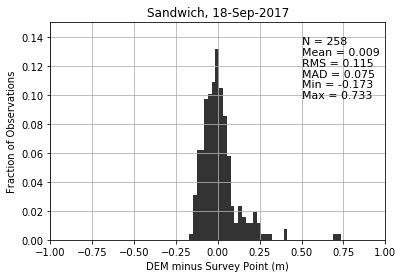

In [24]:
## Histogram of the data
x = df['DEMi_minus_trans'].as_matrix()
x = x[~np.isnan(x)]
x = x[np.abs(x)<5.]

xN = len(x)
xMAD = np.mean(np.abs(x))
xmean = x.mean()
xmin = x.min()
xmax = x.max()
xRMS = np.sqrt(np.mean(x**2))

fig = plt.figure()
# next line must be combined with normed=False to get fractional distribution correct
weights = np.ones_like(x)/float(len(x))
n, bins, patches = plt.hist(x, bins=40, weights=weights, normed=False, facecolor=(.2,.2,.2), alpha=1)
xaxmax = 1
xaxmin = -1
yaxmin = 0.
yaxmax = .15

plt.xlabel('DEM minus Survey Point (m)')
plt.ylabel('Fraction of Observations')
plt.title(ttext)
plt.axis([xaxmin, xaxmax, yaxmin, yaxmax])
plt.grid(True)
plt.text(.75*(xaxmax-xaxmin)+xaxmin,.9*(yaxmax-yaxmin)+yaxmin,'N = {}'.format(xN), fontsize=11)
plt.text(.75*(xaxmax-xaxmin)+xaxmin,.85*(yaxmax-yaxmin)+yaxmin,'Mean = {:.3f}'.format(xmean), fontsize=11)
plt.text(.75*(xaxmax-xaxmin)+xaxmin,.8*(yaxmax-yaxmin)+yaxmin,'RMS = {:.3f}'.format(xRMS), fontsize=11)
plt.text(.75*(xaxmax-xaxmin)+xaxmin,.75*(yaxmax-yaxmin)+yaxmin,'MAD = {:.3f}'.format(xMAD), fontsize=11)
plt.text(.75*(xaxmax-xaxmin)+xaxmin,.7 *(yaxmax-yaxmin)+yaxmin,'Min = {:.3f}'.format(xmin), fontsize=11)
plt.text(.75*(xaxmax-xaxmin)+xaxmin,.65*(yaxmax-yaxmin)+yaxmin,'Max = {:.3f}'.format(xmax), fontsize=11)
plt.show()

fig_name = fdir+"hist_DEM_minus_transect.png"
fig.savefig(fig_name)

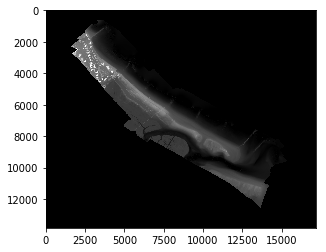

In [12]:
plt.plot(figsize=(12,6));plt.imshow(z[::],cmap=plt.cm.gray,vmin=-2,vmax=13)